# Classifying Wine Varieties
#### Christopher Yue and Vishal Hundal

In [1]:
from scipy import stats
from sklearn import linear_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm

In [2]:
table = pd.read_csv('winemag-data_first150k.csv')
table.drop(['Unnamed: 0'], axis=1, inplace=True)
table = table[['country', 'description', 'province', 'region_1', 'region_2', 'winery', 
               'designation', 'price', 'points', 'variety']]
table = table.dropna()
table

,country,description,province,region_1,region_2,winery,designation,price,points,variety
0,US,This tremendous 100% varietal wine hails from ...,California,Napa Valley,Napa,Heitz,Martha's Vineyard,235.0,96,Cabernet Sauvignon
2,US,Mac Watson honors the memory of a wine once ma...,California,Knights Valley,Sonoma,Macauley,Special Selected Late Harvest,90.0,96,Sauvignon Blanc
3,US,"This spent 20 months in 30% new French oak, an...",Oregon,Willamette Valley,Willamette Valley,Ponzi,Reserve,65.0,96,Pinot Noir
8,US,This re-named vineyard was formerly bottled as...,Oregon,Chehalem Mountains,Willamette Valley,Bergström,Silice,65.0,95,Pinot Noir
9,US,The producer sources from two blocks of the vi...,California,Sonoma Coast,Sonoma,Blue Farm,Gap's Crown Vineyard,60.0,95,Pinot Noir
11,US,"From 18-year-old vines, this supple well-balan...",Oregon,Ribbon Ridge,Willamette Valley,Patricia Green Cellars,Estate Vineyard Wadensvil Block,48.0,95,Pinot Noir
12,US,A standout even in this terrific lineup of 201...,Oregon,Dundee Hills,Willamette Valley,Patricia Green Cellars,Weber Vineyard,48.0,95,Pinot Noir
14,US,"With its sophisticated mix of mineral, acid an...",Oregon,Dundee Hills,Willamette Valley,Domaine Serene,Grace Vineyard,185.0,95,Pinot Noir
15,US,"First made in 2006, this succulent luscious Ch...",Oregon,Willamette Valley,Willamette Valley,Bergström,Sigrid,90.0,95,Chardonnay
16,US,"This blockbuster, powerhouse of a wine suggest...",California,Diamond Mountain District,Napa,Hall,Rainin Vineyard,325.0,95,Cabernet Sauvignon


## Exploratory Data Analysis

In [3]:
def check_for_dups(df):
    seen = set()
    dups = set()
    num_dups = 0
    for index, row in df.iterrows():
        if row['description'] not in seen:
            seen.add(row['description'])
        else:
            dups.add(row['description'])
            num_dups += 1
            
    return dups, num_dups

Duplicate entries can be an issue for Machine Learning model training later on, and I will explain why when we get to the model training section.
To see if duplicates are an issue, I want to check specifically the description column for duplicate entries, because two wines could coincidentally have other features that perfectly match (e.g. region, price, points). The description, however, must be unique to a review.

In [4]:
dups, num_dups = check_for_dups(table)
dups

{"Hard mountain tannins characterize this Cab, which was grown above 2,000 feet in the Mayacamas. It's hugely deep in blackberries and black currants, with notes of dark chocolate and violets. Meanwhile, 100% new French oak adds an elaborate layer of smoky caramel and char that's entirely in keeping with the wine's volume. Impressive and flashy, but immature, this wine requires cellaring. Best 2012–2018.",
 'This is quite an interesting wine, and it just shows how a little creative blending can lift an ordinary wine up. The dominant Sauvignon Blanc brings the usual citrus and grassy acidity, while 8% of Viognier adds flowery perfume, and 10% Verdelho brings more acidity and a lemongrass, green apple edge. Terrific, versatile food wine.',
 "Mountain fruit is the key to understanding this 100% Cab. By that is meant a unique combination of firm, astringent tannins and fabulously concentrated blackberry and currant fruit that absolutely demands aging. It's obvious that the terroir these gr

There seem to be a lot of duplicate descriptions. Let's take a look at exactly how many of those reviews were duplicates.

In [5]:
print('Number of duplicates: ' + str(num_dups))
print('Percentage duplicates: ' + str(num_dups * 100 / len(table)) + '%')

Number of duplicates: 13819
Percentage duplicates: 35.21571825386713%


In [6]:
table.drop_duplicates('description', inplace=True)

In [7]:
dups, num_dups = check_for_dups(table)
num_dups

0

As you can see, approximately 35% of our original data consisted of duplicates. That's a lot of duplicates!
We can take care of this issue by simply dropping all of the rows that contain duplicate descriptions from our data. After running the code above, we are now duplicate-free.

In [8]:
table

,country,description,province,region_1,region_2,winery,designation,price,points,variety
0,US,This tremendous 100% varietal wine hails from ...,California,Napa Valley,Napa,Heitz,Martha's Vineyard,235.0,96,Cabernet Sauvignon
2,US,Mac Watson honors the memory of a wine once ma...,California,Knights Valley,Sonoma,Macauley,Special Selected Late Harvest,90.0,96,Sauvignon Blanc
3,US,"This spent 20 months in 30% new French oak, an...",Oregon,Willamette Valley,Willamette Valley,Ponzi,Reserve,65.0,96,Pinot Noir
8,US,This re-named vineyard was formerly bottled as...,Oregon,Chehalem Mountains,Willamette Valley,Bergström,Silice,65.0,95,Pinot Noir
9,US,The producer sources from two blocks of the vi...,California,Sonoma Coast,Sonoma,Blue Farm,Gap's Crown Vineyard,60.0,95,Pinot Noir
11,US,"From 18-year-old vines, this supple well-balan...",Oregon,Ribbon Ridge,Willamette Valley,Patricia Green Cellars,Estate Vineyard Wadensvil Block,48.0,95,Pinot Noir
12,US,A standout even in this terrific lineup of 201...,Oregon,Dundee Hills,Willamette Valley,Patricia Green Cellars,Weber Vineyard,48.0,95,Pinot Noir
14,US,"With its sophisticated mix of mineral, acid an...",Oregon,Dundee Hills,Willamette Valley,Domaine Serene,Grace Vineyard,185.0,95,Pinot Noir
15,US,"First made in 2006, this succulent luscious Ch...",Oregon,Willamette Valley,Willamette Valley,Bergström,Sigrid,90.0,95,Chardonnay
16,US,"This blockbuster, powerhouse of a wine suggest...",California,Diamond Mountain District,Napa,Hall,Rainin Vineyard,325.0,95,Cabernet Sauvignon


Now I want to get a sense of the different varieties of wine. This would be useful to explore, as our end goal is to train a Machine Learning model to predict the points a wine would receive based on an observation.

In [9]:
print('Varieties:' + str(table['variety'].unique()))

Varieties:['Cabernet Sauvignon' 'Sauvignon Blanc' 'Pinot Noir' 'Chardonnay' 'Rosé'
 'Syrah' 'Riesling' 'Cabernet Sauvignon-Syrah' 'Meritage'
 'Cabernet Sauvignon-Cabernet Franc' 'Moscato' 'Pinot Grigio'
 'Sparkling Blend' 'Zinfandel' 'Barbera' 'Grenache' 'Rhône-style Red Blend'
 'Albariño' 'Bordeaux-style Red Blend' 'Viognier' 'Picpoul' 'Malbec'
 'Cabernet Franc' 'G-S-M' 'Mourvèdre' 'Petit Verdot'
 'Rhône-style White Blend' 'Muscat' 'Cabernet Sauvignon-Merlot' 'Red Blend'
 'Ugni Blanc' 'Grüner Veltliner' 'Merlot' 'White Blend' 'Primitivo'
 'Pinot Gris' 'Gewürztraminer' 'Tempranillo' 'Pinot Blanc'
 'Champagne Blend' 'Nebbiolo' 'Roussanne' 'Touriga Nacional' 'Port'
 'Sangiovese' 'Blaufränkisch' 'Merlot-Cabernet Sauvignon'
 'Sangiovese-Syrah' 'Cabernet Franc-Merlot' 'Sauvignon Blanc-Semillon'
 'Grenache Blanc' 'Petite Sirah' 'Alicante Bouschet' 'Carignane' 'Charbono'
 'Syrah-Mourvèdre' 'Graciano' 'Syrah-Cabernet Sauvignon' 'Verdelho'
 'Petite Verdot' 'Grenache-Syrah' 'Pinot Noir-Syrah' 'G

In [10]:
len(table['variety'].unique())

180

There are 179 different varieties of wine in the data. This is quite a large number, and I want to see exactly how often each variety appears in the data.

In [11]:
varieties_counts = table['variety'].value_counts()
varieties_counts

Pinot Noir                      4830
Cabernet Sauvignon              3245
Chardonnay                      3055
Red Blend                       1876
Syrah                           1792
Zinfandel                       1772
Bordeaux-style Red Blend        1100
Merlot                           945
Sauvignon Blanc                  762
Riesling                         686
Sparkling Blend                  422
Rhône-style Red Blend            379
Rosé                             359
White Blend                      351
Cabernet Franc                   305
Petite Sirah                     304
Viognier                         269
Pinot Gris                       215
Sangiovese                       211
Malbec                           164
Grenache                         163
Gewürztraminer                   160
Rhône-style White Blend          148
Tempranillo                      102
Meritage                          99
Cabernet Blend                    90
Pinot Grigio                      85
B

Looking at these results, many of the wine varieties have too few observations (the section right after the ellipsis solely consists of 1s). Let's agree that saying a variety with "too few" observations means that the specific variety has fewer than 100 occurences. It may be wise to remove these varieties, as leaving them in the data will not help facilitate data analysis.

In [12]:
varieties_enough = set()
for variety in varieties_counts.index:
    if varieties_counts[variety] >= 100:
        varieties_enough.add(variety)
print(type(table['variety']))
table = table.loc[table['variety'].isin(varieties_enough)]
table.reset_index(inplace=True)
table.drop(columns=['index'], inplace=True)
table

<class 'pandas.core.series.Series'>


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,country,description,province,region_1,region_2,winery,designation,price,points,variety
0,US,This tremendous 100% varietal wine hails from ...,California,Napa Valley,Napa,Heitz,Martha's Vineyard,235.0,96,Cabernet Sauvignon
1,US,Mac Watson honors the memory of a wine once ma...,California,Knights Valley,Sonoma,Macauley,Special Selected Late Harvest,90.0,96,Sauvignon Blanc
2,US,"This spent 20 months in 30% new French oak, an...",Oregon,Willamette Valley,Willamette Valley,Ponzi,Reserve,65.0,96,Pinot Noir
3,US,This re-named vineyard was formerly bottled as...,Oregon,Chehalem Mountains,Willamette Valley,Bergström,Silice,65.0,95,Pinot Noir
4,US,The producer sources from two blocks of the vi...,California,Sonoma Coast,Sonoma,Blue Farm,Gap's Crown Vineyard,60.0,95,Pinot Noir
5,US,"From 18-year-old vines, this supple well-balan...",Oregon,Ribbon Ridge,Willamette Valley,Patricia Green Cellars,Estate Vineyard Wadensvil Block,48.0,95,Pinot Noir
6,US,A standout even in this terrific lineup of 201...,Oregon,Dundee Hills,Willamette Valley,Patricia Green Cellars,Weber Vineyard,48.0,95,Pinot Noir
7,US,"With its sophisticated mix of mineral, acid an...",Oregon,Dundee Hills,Willamette Valley,Domaine Serene,Grace Vineyard,185.0,95,Pinot Noir
8,US,"First made in 2006, this succulent luscious Ch...",Oregon,Willamette Valley,Willamette Valley,Bergström,Sigrid,90.0,95,Chardonnay
9,US,"This blockbuster, powerhouse of a wine suggest...",California,Diamond Mountain District,Napa,Hall,Rainin Vineyard,325.0,95,Cabernet Sauvignon


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]), <a list of 24 Text xticklabel objects>)

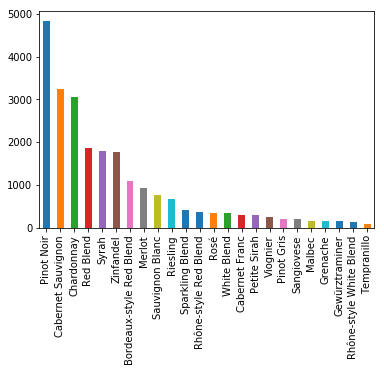

In [13]:
table['variety'].value_counts().plot(kind='bar', rot=0)
plt.xticks(rotation=90)

In [14]:
varieties = {}

To train our model, we are going to have to convert all of our categorical features (i.e. text) into continuous features (i.e. numbers). This is a very common process that is performed for training Machine Learning models, as features are often categorical in datasets. Machine Learning algorithms work purely with numbers to perform various tasks such as regression (e.g. predicting housing prices when given the square footage and location of a house) and classification (e.g. predicting whether or not a tumor is malignant, given the mass of the tumor). We will convert all of the categorical features except for the description feature, which we will touch on this in a bit.

In [15]:
to_discretize = ['country', 'province', 'region_1', 'region_2', 'winery', 'designation', 'variety']

for col_name in to_discretize:
    table[col_name] = table[col_name].astype('category')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [16]:
cat_columns = table.select_dtypes(['category']).columns
table[cat_columns] = table[cat_columns].apply(lambda x: x.cat.codes)
table.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,country,description,province,region_1,region_2,winery,designation,price,points,variety
0,0,This tremendous 100% varietal wine hails from ...,0,103,7,1317,5451,235.0,96,2
1,0,Mac Watson honors the memory of a wine once ma...,0,65,13,1792,8245,90.0,96,17
2,0,"This spent 20 months in 30% new French oak, an...",2,196,17,2273,7098,65.0,96,10
3,0,This re-named vineyard was formerly bottled as...,2,26,17,289,8007,65.0,95,10
4,0,The producer sources from two blocks of the vi...,0,165,13,337,3564,60.0,95,10


Taking another look at our data, I am highly suspicious of there being a correlation between the price of a wine and the number of points it receives. We can plot a graph of these two variables to get an idea of their relationship.

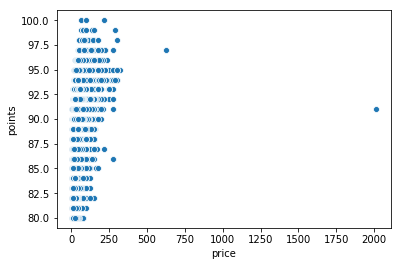

In [17]:
sns.scatterplot(x=table['price'], y=table['points'])

It looks like there are some outliers that are distorting the graph. We can remove them and then plot the graph again.

In [18]:
table = table[np.abs(table['points'] - table['points'].mean()) <= (3*table['points'].std())]
table = table[np.abs(table['price'] - table['price'].mean()) <= (3*table['price'].std())]

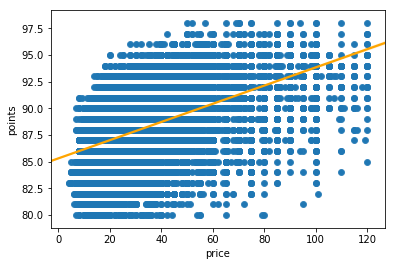

In [19]:
sns.scatterplot(x=table['price'], y=table['points'])
sns.regplot(x=table['price'], y=table['points'], line_kws={'color': 'orange'})

It looks like there is a rough linear relationship between the price of a wine and the number of points it receives from a review.
We can see how correlated these two continuous variables are by finding the Pearson Correlation Coefficient between them.

In [20]:
stats.pearsonr(x=table['price'], y=table['points'])[0]

0.49298192779096905

A Pearson Correlation Coefficient value of 0.488 means that there is a moderate positive relationship between the price and points of a wine (a value of 1 would represent a positive relationship and a value of -1 would represent a negative relationship). We can see how much the number of points increases on average for every dollar added to the price.

In [21]:
res = sm.OLS(table['price'], table['points']).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                 9.001e+04
Date:                Wed, 12 Dec 2018   Prob (F-statistic):               0.00
Time:                        07:20:44   Log-Likelihood:            -1.0119e+05
No. Observations:               23244   AIC:                         2.024e+05
Df Residuals:                   23243   BIC:                         2.024e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
points         0.4183      0.001    300.014      0.0

The linear regression followed the formula y = mx + b. With m being "coef" in the OLS Regression Results, the number of points a wine receives increases by 0.4133 per every dollar, on average.

In [22]:
features = table.loc[:, 'country':'points']
label = table['variety']